# Add Dependencies

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
!pip install -Uqq fastai
!pip install nbdev

# Image Classification

In [2]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_cat(x): 
    return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.171250,0.026436,0.011502,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.055546,0.015066,0.006089,00:21


There are various different classes for different kinds of deep learning datasets and problems—here we're using `ImageDataLoaders`. The first part of the class name will generally be the type of data you have, such as image, or text.

`valid_pct=0.2` tells fastai to hold out 20% of the data for the validation set.

`seed=42` sets the random seed to the same value every time, which means we get the same validation set every time we run it.

`Transform` contains code that is applied automatically during training; fastai includes many predefined Transforms, and adding new ones is as simple as creating a Python function. There are two kinds: `item_tfms` are applied to each item, while `batch_tfms` are applied to a batch of items at a time using the GPU, so they're particularly fast.

`error_rate`, which is a function provided by fastai that does just what it says: tells you what percentage of images in the validation set are being classified incorrectly. Another common metric for classification is `accuracy` (which is just 1.0 - error_rate).


The code training our image recognizer tells fastai to create a convolutional neural network (CNN) and specifies what architecture to use (i.e. what kind of model to create), what data we want to train it on, and what metric to use:

`learn = vision_learner(dls, resnet34, metrics=error_rate)`

`vision_learner` also has a parameter pretrained, which defaults to True (so it's used in this case, even though we haven't specified it), which sets the weights in your model to values that have already been trained by experts to recognize a thousand different categories across 1.3 million photos.

When using a pretrained model, `vision_learner` will remove the last layer, since that is always specifically customized to the original training task (i.e. ImageNet dataset classification), and replace it with one or more new layers with randomized weights, of an appropriate size for the dataset you are working with. This last part of the model is known as the head.


Why a CNN? It's the current state-of-the-art approach to creating computer vision models. We'll be learning all about how CNNs work. Their structure is inspired by how the human vision system works.

There are many different architectures in fastai. Most of the time, however, picking an architecture isn't a very important part of the deep learning process. It's something that academics love to talk about, but in practice it is unlikely to be something you need to spend much time on. There are some standard architectures that work most of the time, and in this case we're using one called `ResNet`; it is both fast and accurate for many datasets and problems. The 34 in resnet34 refers to the number of layers in this variant of the architecture (other options are 18, 50, 101, and 152). Models using architectures with more layers take longer to train, and are more prone to overfitting (i.e. you can't train them for as many epochs before the accuracy on the validation set starts getting worse). On the other hand, when using more data, they can be quite a bit more accurate.


When you use the `fine_tune` method, fastai will use these tricks for you. There are a few parameters you can set (which we'll discuss later), but in the default form shown here, it does two steps:

1. Use one epoch to fit just those parts of the model necessary to get the new random head to work correctly with your dataset.

2. Use the number of epochs requested when calling the method to fit the entire model, updating the weights of the later layers (especially the head) faster than the earlier layers (which, as we'll see, generally don't require many changes from the pretrained weights).


In 2013 a PhD student, Matt Zeiler, and his supervisor, Rob Fergus, published the paper ["Visualizing and Understanding Convolutional Networks"](https://arxiv.org/pdf/1311.2901.pdf), which showed how to visualize the neural network weights learned in each layer of a model. They carefully analyzed the model that won the 2012 ImageNet competition, and used this analysis to greatly improve the model, such that they were able to go on to win the 2013 competition!

# Segmentation

Let's talk about something that is critically important for autonomous vehicles: localizing objects in a picture. If a self-driving car doesn't know where a pedestrian is, then it doesn't know how to avoid one! Creating a model that can recognize the content of every individual pixel in an image is called segmentation.

In [5]:
path = untar_data(URLs.CAMVID_TINY)

dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,3.211246,2.509051,00:01


epoch,train_loss,valid_loss,time
0,1.921855,1.479190,00:01
1,1.645318,1.293809,00:01
2,1.495696,1.100697,00:01
3,1.342203,0.928481,00:01
4,1.214650,0.775340,00:01
5,1.099217,0.732727,00:01
6,1.004061,0.707962,00:01
7,0.928706,0.694797,00:01


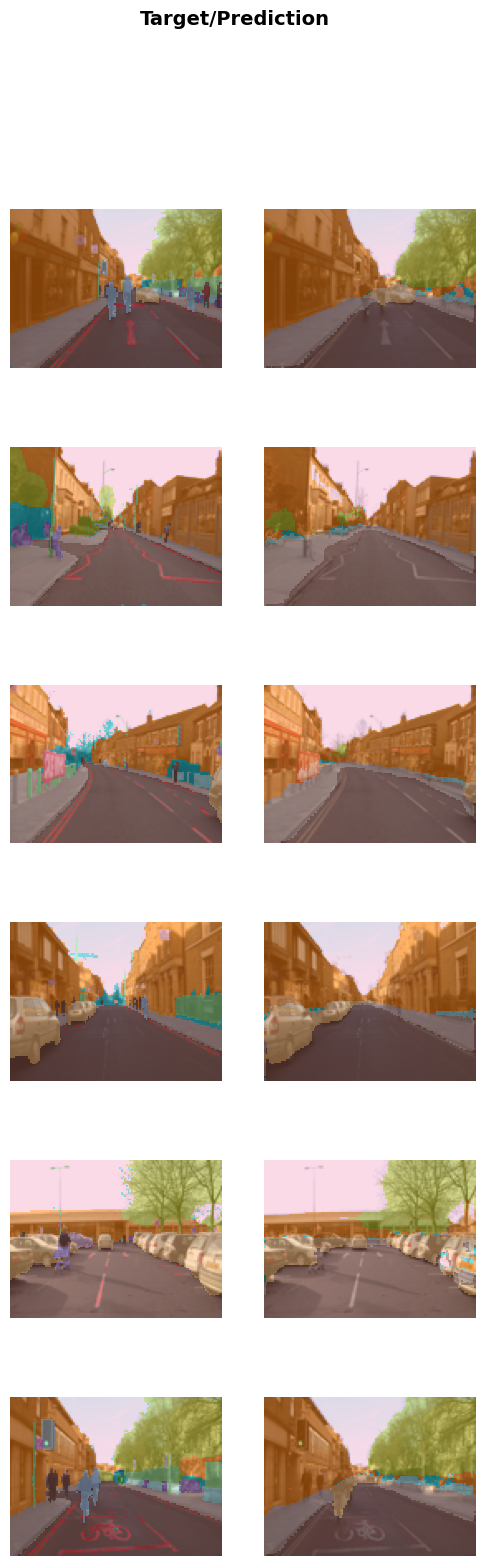

In [12]:
learn.show_results(max_n=6)

# Text Classification

One other area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). Computers can now generate text, translate automatically from one language to another, analyze comments, label words in sentences, and much more. Here is all of the code necessary to train a model that can classify the sentiment of a movie review better than anything that existed in the world just five years ago:


In [2]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=16)

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.515793,0.444335,0.809480,04:56


epoch,train_loss,valid_loss,accuracy,time
0,0.333212,0.280631,0.879960,08:24
1,0.228151,0.268164,0.897960,08:24
2,0.218961,0.190375,0.929040,08:24
3,0.134505,0.189365,0.931800,08:24


If you hit a "CUDA out of memory error" after running this cell, click on the menu Kernel, then restart. Instead of executing the cell above, copy and paste the following code in it:

In [ ]:
# from fastai.text.all import *

# dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=16)
# learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
# learn.fine_tune(4, 1e-2)

This reduces the batch size to 32. If you keep hitting the same error, change 32 to 16.

This model is using the "IMDb Large Movie Review dataset" from the paper "Learning Word Vectors for Sentiment Analysis" by Andrew Maas et al. It works well with movie reviews of many thousands of words, but let's test it out on a very short one to see how it does its thing:

In [ ]:
learn.predict("I really liked that movie!")

Here we can see the model has considered the review to be positive. The second part of the result is the index of "pos" in our data vocabulary and the last part is the probabilities attributed to each class (99.6% for "pos" and 0.4% for "neg").

If you ever have any questions about a fastai method, you should use the function doc, passing it the method name:

```
doc(learn.predict)

```

# Tabular Data

Let's move on to something much less sexy, but perhaps significantly more widely commercially useful: building models from plain tabular data.
Here is the code necessary to train a model that will predict whether a person is a high-income earner, based on their socioeconomic background:

In [3]:
from fastai.tabular.all import *

path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

As you see, we had to tell fastai which columns are categorical (that is, contain values that are one of a discrete set of choices, such as occupation) and which are continuous (that is, contain a number that represents a quantity, such as age).

In [6]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.378963,0.368383,0.829238,00:04
1,0.367978,0.351811,0.839834,00:04
2,0.352837,0.350572,0.841063,00:04


This model is using the Adult dataset, from the paper "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid" by Rob Kohavi, which contains some demographic data about individuals (like their education, marital status, race, sex, and whether or not they have an annual income greater than $50k). The model is over 80% accurate, and took around 30 seconds to train.

# Recommendation Systems

Let's look at one more. Recommendation systems are very important, particularly in e-commerce. Companies like Amazon and Netflix try hard to recommend products or movies that users might like. Here's how to train a model that will predict movies people might like, based on their previous viewing habits, using the MovieLens dataset:

In [7]:
from fastai.collab import *

path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5, 5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.507245,1.432383,00:00


epoch,train_loss,valid_loss,time
0,1.360451,1.373048,00:00
1,1.266998,1.189308,00:00
2,1.027130,0.881640,00:00
3,0.792047,0.739559,00:00
4,0.681843,0.706473,00:00
5,0.651358,0.693254,00:00
6,0.634185,0.688708,00:00
7,0.619342,0.685874,00:00
8,0.623172,0.685044,00:00
9,0.614823,0.684930,00:00


This model is predicting movie ratings on a scale of 0.5 to 5.0 to within around 0.6 average error. Since we're predicting a continuous number, rather than a category, we have to tell fastai what range our target has, using the y_range parameter.


Although we're not actually using a pretrained model (for the same reason that we didn't for the tabular model), this example shows that fastai lets us use fine_tune anyway in this case. Sometimes it's best to experiment with fine_tune versus fit_one_cycle to see which works best for your dataset.

We can use the same show_results call we saw earlier to view a few examples of user and movie IDs, actual ratings, and predictions:


In [8]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,80.0,7.0,4.0,4.104553
1,44.0,9.0,3.5,3.811267
2,70.0,62.0,4.5,4.303179
3,11.0,44.0,3.5,3.036502
4,95.0,36.0,3.0,3.672536
5,39.0,1.0,4.0,3.852183
6,27.0,72.0,2.5,3.128226
7,94.0,29.0,4.5,4.297773
8,67.0,82.0,3.5,3.269573


# Datasets: Food for Models

You’ve already seen quite a few models in this section, each one trained using a different dataset to do a different task. In machine learning and deep learning, we can’t do anything without data. So, the people that create datasets for us to train our models on are the (often underappreciated) heroes. Some of the most useful and important datasets are those that become important academic baselines; that is, datasets that are widely studied by researchers and used to compare algorithmic changes. Some of these become household names (at least, among households that train models!), such as MNIST, CIFAR-10, and ImageNet.

# Validation Sets and Test Sets

As we've discussed, the goal of a model is to make predictions about data. But the model training process is fundamentally dumb. If we trained a model with all our data, and then evaluated the model using that same data, we would not be able to tell how well our model can perform on data it hasn’t seen. Without this very valuable piece of information to guide us in training our model, there is a very good chance it would become good at making predictions about that data but would perform poorly on new data.

To avoid this, our first step was to split our dataset into two sets: the training set (which our model sees in training) and the validation set, also known as the development set (which is used only for evaluation). This lets us test that the model learns lessons from the training data that generalize to new data, the validation data.

To do a good job of defining a validation set (and possibly a test set), you will sometimes want to do more than just randomly grab a fraction of your original dataset. Remember: a key property of the validation and test sets is that they must be representative of the new data you will see in the future. This may sound like an impossible order! By definition, you haven’t seen this data yet. But you usually still do know some things.

One case might be if you are looking at time series data. For a time series, choosing a random subset of the data will be both too easy (you can look at the data both before and after the dates you are trying to predict) and not representative of most business use cases (where you are using historical data to build a model for use in the future). If your data includes the date and you are building a model to use in the future, you will want to choose a continuous section with the latest dates as your validation set (for instance, the last two weeks or last month of available data).

For example, Kaggle had a competition to predict the sales in a chain of Ecuadorian grocery stores. Kaggle's training data ran from Jan 1 2013 to Aug 15 2017, and the test data spanned Aug 16 2017 to Aug 31 2017. That way, the competition organizer ensured that entrants were making predictions for a time period that was in the future, from the perspective of their model. This is similar to the way quant hedge fund traders do back-testing to check whether their models are predictive of future periods, based on past data.

A second common case is when you can easily anticipate ways the data you will be making predictions for in production may be qualitatively different from the data you have to train your model with.

In the Kaggle distracted driver competition, the independent variables are pictures of drivers at the wheel of a car, and the dependent variables are categories such as texting, eating, or safely looking ahead. Lots of pictures are of the same drivers in different positions. If you were an insurance company building a model from this data, note that you would be most interested in how the model performs on drivers it hasn't seen before (since you would likely have training data only for a small group of people). In recognition of this, the test data for the competition consists of images of people that don't appear in the training set.
